Goal: create maps of street networks, but only within a buffer around a geocoded place.

Next goal: functions to measure and visualize urban indicators.

Steps:
- write code to plot heatmap of point density [DONE]
- convert heatmap code to function
- write code to clip heatmap to buffer ring
- write code to get osm amenity data based on category

Ideas for Urban Indicators:
- street density (hexbin/heatmap)
- intersection density (hexbin/heatmap)
- density of x-height buildings (hexbin/heatmap)
- density of x kind of amenity (hexbin/heatmap)
- isochrone from geocoded point

In [14]:
import osmnx as ox
import geopandas as gpd
import contextily as cx
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

In [2]:
# PLACE_NAMES = [
#     # "Marikina, Metro Manila",
#     # "Quezon City, Metro Manila",
#     # "Manila, Metro Manila",
#     "Pasig, Metro Manila",
#     # "Taguig, Metro Manila"
# ]

In [3]:
# Set name for Nominatim query
query = "Balulang, Cagayan de Oro"
buffer_dist = 1_500

# Get buffer with aforementioned parameters using custom function
from urban_indicators_scripts import get_buffer_from_place

buffer = get_buffer_from_place(query, buffer_dist)

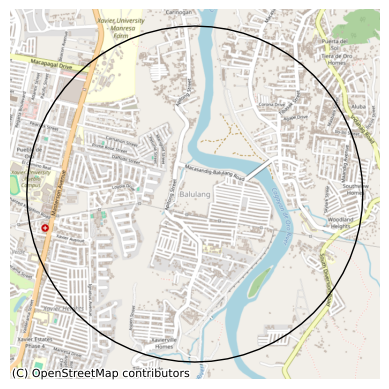

In [4]:
# Check if buffer location is correct
ax = buffer.to_crs("EPSG:3857").plot(
    facecolor="none"
)
cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

In [5]:
# Get road network within buffer
graph = ox.graph_from_polygon(
    buffer.geometry[0],
    network_type="all_private",
    retain_all=True
)

# Convert intersections and streets to geodataframe
intersections, streets = ox.graph_to_gdfs(graph)

In [6]:
# Reproject both GDFs to pseudo-mercator
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [7]:
# Parse `lanes` column in streets GDF using custom function
from urban_indicators_scripts import parse_street_lanes

streets = parse_street_lanes(streets)
streets.lanes.unique()

array([4, 1, 2])

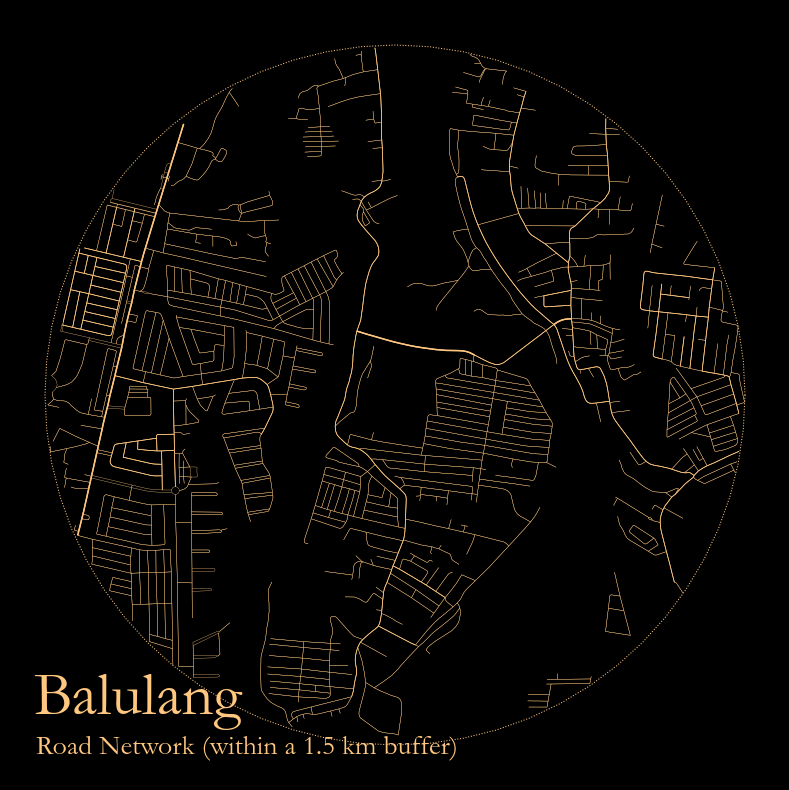

In [8]:
# Plot street network
from urban_indicators_scripts import plot_streets

plot_streets(
    streets,
    buffer,
    color_scheme="copper"
)

Examining the street intersections GDF

C:\Users\Kurt\AppData\Local\Temp\ipykernel_8800\432011039.py:8: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
C:\Users\Kurt\AppData\Local\Temp\ipykernel_8800\432011039.py:10: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(


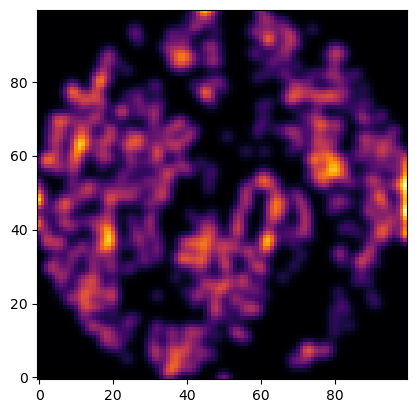

In [48]:
heatmap, xedges, yedges = np.histogram2d(
    x = intersections["y"],
    y = intersections["x"],
    bins = 100,
    density = True
)

logheatmap = np.log(heatmap)
logheatmap[np.isneginf(logheatmap)] = 0
logheatmap = ndimage.filters.gaussian_filter(
    logheatmap,
    1.5,
    mode="nearest",
    radius=200
)

plt.imshow(
    logheatmap,
    cmap="inferno",
    alpha=1.0,
    origin="lower"
)